# Assignment 9 Logistic Regression

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

## Titanic Data

You will conduct logistic regression on the Titanic dataset. The data variables are

Target
+ Survived: 0 = No, 1 = Yes

Predictors
+ Pclass:  passenger class (1 = first class, 2 = second class, and 3 = third class)
+ SexNum: gender of the passengers
+ Age:  age of the passengers
+ SibSp: number of siblings/spouses aboard
+ Parch: number of parents/children aboard
+ Fare:   passenger fares
+ Embarked: port of embarkation (C = Cherbourg,Q = Queenstown, and S = Southampton)

In [2]:
# read data
df =  pd.read_csv("titanic_log.csv")

In [3]:
# display data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    object 
 3   Age          714 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Embarked     889 non-null    object 
 8   Survived     891 non-null    int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


## Data Preprocessing

In [5]:
# check for missing values?
df.isna().sum()

PassengerId      0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
Survived         0
dtype: int64

In [9]:
# drop all missing values in the data frame
df = df.dropna()
df.shape

(712, 9)

In [10]:
# To change male and female to male = 1 and female = 2
# you will first create  a dictionary of values for male and female

dict = {'male': '1', 'female': '2'}

In [11]:
# Next, map the Sex field from male & female to 1 & 2
# this also adds the field Sexnum to the data frame
df['SexNum'] = df['Sex'].map(dict)

In [12]:
# Change sex number to an integer in place
df['SexNum'] = df['SexNum'].astype('int')
# check result
df.SexNum.head()

0    1
1    2
2    2
3    2
4    1
Name: SexNum, dtype: int64

## Data Visualization

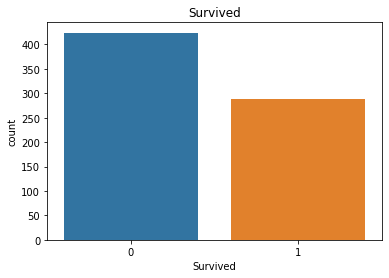

In [13]:
# create a Seaborn count plot of the Target which is survived
sns.countplot(x='Survived',data=df)
plt.title('Survived');

<AxesSubplot:xlabel='Survived', ylabel='count'>

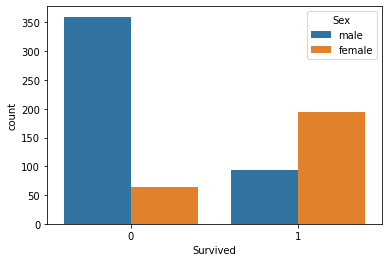

In [14]:
# Create a grouped count plot of Survived and Sex Hint: use hue for Sex
sns.countplot(x="Survived", hue="Sex", data=df)

<Figure size 720x720 with 0 Axes>

Text(0.5, 0, 'Survived')

Text(0, 0.5, 'siblings/spouses')

Text(0.5, 1.0, 'Grouped bar plot of Survivued && Siblings/spouses')

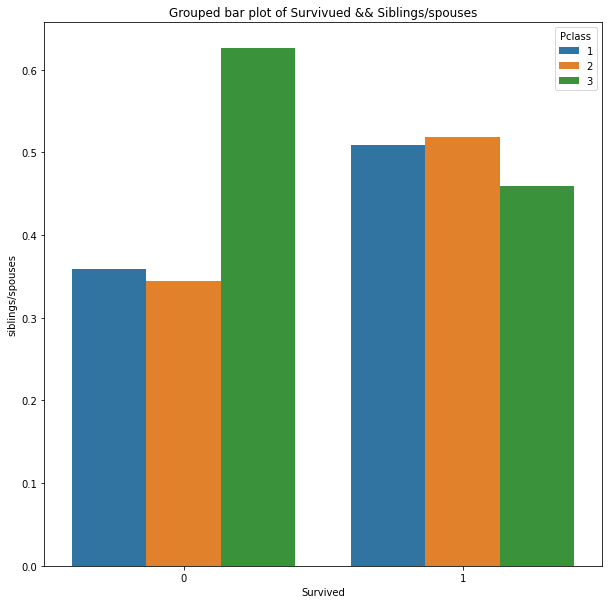

In [20]:
# Create a grouped bar plot of Survived and siblings/spouses with chart title and axes labelsl
# Hint: use hue for Pclass
plt.figure(figsize=(10, 10))
ax = sns.barplot(x="Survived", y="SibSp", hue="Pclass", data=df, ci=None);
ax.set_xlabel("Survived")
ax.set_ylabel("siblings/spouses")
ax.set_title("Grouped bar plot of Survivued && Siblings/spouses")

In [21]:
# in a research paper, if you wanted to report the numbers 
# that survived by (for exmample)Sex 
# you would get that from a Pandas cross table of Survived and Sex
# creating a contigency table
crosstab = pd.crosstab(df.Survived, df.Sex,margins=True,margins_name="Total")
crosstab


Sex,female,male,Total
Survived,,,
0,64,360,424
1,195,93,288
Total,259,453,712


# Feature and Target Selection

In [22]:
# The Target is survived
# Features are: sex as a number, Age, and number of siblings/spouses on board
# Select the features and the target and save them in variables
features = df[['SexNum', 'Age','SibSp']]
target = df.Survived


In [25]:
# Logistic Regression Assumptions to be met:
# dependent variable must be categorical with two values
# independent variables(features) must not be collinear - check with df.corr()
df.corr()
# check dependent variable (i.e. target) categorical with two values
# hint: use value counts
target.value_counts()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived,SexNum
PassengerId,1.000000,-0.035609,0.033681,-0.082704,-0.011672,0.009655,0.029526,-0.024674
Pclass,-0.035609,1.000000,-0.365902,0.065187,0.023666,-0.552893,-0.356462,-0.150826
Age,0.033681,-0.365902,1.000000,-0.307351,-0.187896,0.093143,-0.082446,-0.099037
SibSp,-0.082704,0.065187,-0.307351,1.000000,0.383338,0.139860,-0.015523,0.106296
Parch,-0.011672,0.023666,-0.187896,0.383338,1.000000,0.206624,0.095265,0.249543
Fare,0.009655,-0.552893,0.093143,0.139860,0.206624,1.000000,0.266100,0.182457
Survived,0.029526,-0.356462,-0.082446,-0.015523,0.095265,0.266100,1.000000,0.536762
SexNum,-0.024674,-0.150826,-0.099037,0.106296,0.249543,0.182457,0.536762,1.000000


0    424
1    288
Name: Survived, dtype: int64

In [26]:
# check features not collinear? use correlation
features.corr()


,SexNum,Age,SibSp
SexNum,1.000000,-0.099037,0.106296
Age,-0.099037,1.000000,-0.307351
SibSp,0.106296,-0.307351,1.000000


<AxesSubplot:>

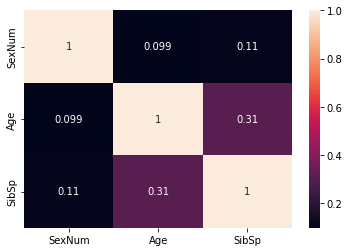

In [27]:
# Use this code to create a Seaborn correlation heatmap
sns.heatmap(features.corr().abs(),annot=True)


In [55]:
# split data into train and test sets. Your test size should be 30%

x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.30,random_state=1)

In [60]:
# Logistic regression model. Hint: remember to use a formula
formula = 'Survived ~ C(Sex) + Age + SipSp'
model = sm.Logit(y_train, x_train).fit()

Optimization terminated successfully.
         Current function value: 0.593976
         Iterations 5


In [61]:
# display model results summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  498
Model:                          Logit   Df Residuals:                      495
Method:                           MLE   Df Model:                            2
Date:                Thu, 21 Oct 2021   Pseudo R-squ.:                  0.1183
Time:                        14:14:00   Log-Likelihood:                -295.80
converged:                       True   LL-Null:                       -335.48
Covariance Type:            nonrobust   LLR p-value:                 5.843e-18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SexNum         1.2484      0.162      7.723      0.000       0.932       1.565
Age           -0.0545      0.007     -8.230      0.000      -0.067      -0.042
SibSp         -0.5649      0.118     -4.802      0.000      -0.795      -0.334
==============================================================================
"""

In [62]:
# apply model to test data & make a prediction of the y values with the model
modelpredictions = np.round(model.predict(x_test))
# calculate the residuals
residuals = y_test - modelpredictions

In [63]:
# test are the residuals normal?
print('mean of residuals =', np.mean(residuals))

mean of residuals = -0.04672897196261682


In [64]:
# display the confusion matrix 
cm = pd.crosstab(y_test,modelpredictions)
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 col_0     0.0  1.0
Survived          
0          87   39
1          29   59


In [65]:
# fill in the formulas for the confusion matrix elements
TN = cm[0][0]   
FN = cm[0][1]
FP = cm[1][0]
TP = cm[1][1]

print('\ntrue negative=',TN)
print('False negative=', FN)
print('False positive=', FP)
print('true positive =', TP)


true negative= 87
False negative= 29
False positive= 39
true positive = 59


In [66]:
# Analysis:
# How many observation are in this study? 
## 498 observations
# State which predictor variable(s)are significant. Justify your answer?
## SexNum and Siblings/spouses are significant as they have good coefficients

# Referring to the Pseudo R-square, what percentage of the value of the target
# is predicted by the linear combination of the predictors? 
## 12% is predicted
# Calculate and print the following:
precision   = TP/(TP+FP)
specificity = TN/(TN+FP)

print('\n Precision=',round(precision,2))
print('\n Specificity=',round(specificity,3))

# Complete this sentence
# The fraction with a positive test who had the disease was? 0.6



 Precision= 0.6

 Specificity= 0.69


[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'Actual')]

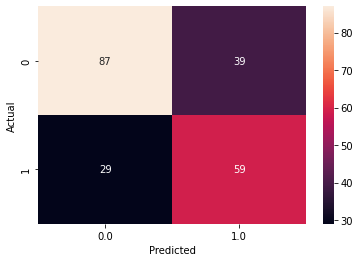

In [67]:
# create a Seaborn heatmap of the confusion matrix
ax = sns.heatmap(cm, annot=True)
ax.set(xlabel='Predicted',ylabel='Actual')
plt.show()

In [68]:
# calculate and display the accuracy score
print('\n\naccuracy =', round((TP + TN)/ (TP +TN + FN + FP),2))
accuracy_score(y_test,modelpredictions)



accuracy = 0.68


0.6822429906542056

In [69]:
# Calculate the Area under ROC
fpr, tpr, _ = roc_curve(y_test, modelpredictions)
auc = roc_auc_score(y_test, modelpredictions)

Area under the ROC curve = 0.6804653679653679


[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

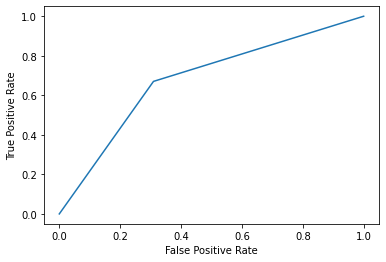

In [70]:
# plot the area under the ROC curve
print("Area under the ROC curve =", auc)
ax = sns.lineplot(x=fpr,y=tpr)
ax.set(xlabel='False Positive Rate',ylabel='True Positive Rate')
plt.show()

# End of Lesson